In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer

In [188]:
import os

# User selections
# List to store DataFrames for each user
user_choices = []

# Get all files from the user_output directory
user_files = os.listdir("../../data/user_output/")

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

df_pueblos = pd.read_csv("../../data/interim/pueblos_recommender.csv")


In [189]:
df_pueblos

,cmun,province,municipality,altitude,longitude,latitude,0-17,18-24,25-34,35-54,...,enc_16,enc_17,enc_18,enc_19,enc_20,enc_21,enc_22,enc_23,enc_24,enc_25
0,48067,Bizkaia,Muxika,18.95764,-2.692941,43.28967,302,96,101,463,...,0.521190,1.185980,1.062733,0.721064,-0.213326,0.750134,1.424322,0.386912,0.224831,0.482462
1,15064,A Coruña,Paderne,151.44100,-8.176355,43.28677,265,119,160,648,...,1.199804,0.865604,0.284170,0.721064,2.110809,-0.135614,1.424322,0.731121,0.639890,1.260643
2,15039,A Coruña,Irixoa,362.87660,-8.058925,43.28474,119,61,95,364,...,0.350131,0.279576,-0.105112,0.721064,1.077860,-0.236198,1.424322,-0.397119,-0.021610,0.371063
3,48062,Bizkaia,Mendata,107.88860,-2.633333,43.28333,58,28,32,113,...,-0.413611,0.994147,0.284170,0.721064,-0.213326,0.732753,1.424322,-0.397119,0.299412,-0.413576
4,48905,Bizkaia,Zamudio,44.55854,-2.866667,43.28333,528,226,291,1016,...,1.939453,2.815453,2.619860,0.721064,0.819623,0.890158,3.771941,6.343633,0.952805,1.977473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,29057,Málaga,Genalguacil,508.32510,-5.235879,36.54427,44,16,32,106,...,-0.395943,1.096759,1.062733,0.721064,0.561385,-0.174132,0.250512,-0.397119,0.125931,-0.374828
6666,11025,Cádiz,Paterna de Rivera,125.97050,-5.866053,36.52333,966,460,630,1791,...,3.709472,7.126529,-0.494394,0.721064,-0.729801,1.572083,0.250512,2.413918,1.029007,3.574197
6667,29056,Málaga,Gaucín,609.39610,-5.317524,36.51830,250,101,139,450,...,0.558132,1.842909,0.284170,0.721064,1.077860,0.602008,0.250512,0.511210,0.578280,0.532511
6668,11001,Cádiz,Alcalá de los Gazules,158.39630,-5.723718,36.46045,793,445,670,1564,...,3.480590,3.239257,-0.883675,0.721064,-0.471564,1.345819,0.250512,2.413918,0.552338,3.398218


In [190]:
from scipy.stats import pearsonr

# Filter encoded features from pueblos data
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)

# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# select the second user from our data
selected_villages = user_choices[1]

display(selected_villages)

# Check if the column exists before dropping it
if "Unnamed: 0" in selected_villages.columns:
    selected_villages = selected_villages.drop("Unnamed: 0", axis=1)

df_selected_enc = selected_villages.filter(regex=r"^enc_", axis=1)
selected_numerical_features = df_selected_enc.loc[:, ~(df_selected_enc.isin([0.0, 1.0]).all())]

display(selected_numerical_features)

# Compute the selection profile as the mean of the selected villages
selection_profile = selected_numerical_features.mean()

display(selection_profile)

# Calculate Pearson correlation with each village
correlation_scores = []
for idx, row in pueblos_numerical_features.iterrows():
    # Extract only the columns that exist in both dataframes
    common_columns = list(set(selection_profile.index) & set(row.index))
    
    if len(common_columns) > 1:  # Need at least 2 points for correlation
        correlation, _ = pearsonr(selection_profile[common_columns], row[common_columns])
    else:
        correlation = 0  # Default if not enough common columns
        
    correlation_scores.append(correlation)

# Add the correlation scores to the DataFrame
df_pueblos['pearson_correlation'] = correlation_scores

# Show the top 10 most similar villages
top_villages = df_pueblos.nlargest(5, 'pearson_correlation')
print(top_villages[['municipality', 'province', 'pearson_correlation']])

,cmun,province,municipality,altitude,longitude,latitude,0-17,18-24,25-34,35-54,...,enc_16,enc_17,enc_18,enc_19,enc_20,enc_21,enc_22,enc_23,enc_24,enc_25
0,49134,Zamora,Muelas de los Caballeros,994.2617,-6.337414,42.12816,7,6,17,46,...,-0.568608,-0.742579,-0.883675,-1.242798,-0.471564,-0.752988,-0.336392,-0.397119,-0.138345,-0.578253
1,14060,Córdoba,Santaella,238.2158,-4.845094,37.56627,886,352,504,1355,...,3.037282,2.151142,0.284170,0.721064,-0.213326,1.192061,0.250512,1.056207,-0.024852,3.047875
2,34176,Palencia,Sotobañado y Priorato,893.8764,-4.441792,42.59135,24,9,11,36,...,-0.593504,-0.692354,-0.883675,-0.260867,0.303148,-0.198741,-0.336392,-0.397119,0.004332,-0.597627
3,9410,Burgos,Valle de Mena,316.4509,-3.283333,43.10000,608,234,345,1292,...,2.610037,1.126481,-0.883675,0.721064,-0.729801,0.709243,0.250512,1.830676,0.338324,2.599049
4,22149,Huesca,Loarre,778.4832,-0.624916,42.31464,19,23,26,99,...,-0.438507,-0.281087,-0.494394,0.721064,1.077860,-0.185835,0.250512,-0.397119,-0.206440,-0.449094


,enc_16,enc_17,enc_18,enc_19,enc_20,enc_21,enc_22,enc_23,enc_24,enc_25
0,-0.568608,-0.742579,-0.883675,-1.242798,-0.471564,-0.752988,-0.336392,-0.397119,-0.138345,-0.578253
1,3.037282,2.151142,0.284170,0.721064,-0.213326,1.192061,0.250512,1.056207,-0.024852,3.047875
2,-0.593504,-0.692354,-0.883675,-0.260867,0.303148,-0.198741,-0.336392,-0.397119,0.004332,-0.597627
3,2.610037,1.126481,-0.883675,0.721064,-0.729801,0.709243,0.250512,1.830676,0.338324,2.599049
4,-0.438507,-0.281087,-0.494394,0.721064,1.077860,-0.185835,0.250512,-0.397119,-0.206440,-0.449094


enc_16    0.809340
enc_17    0.312321
enc_18   -0.572250
enc_19    0.131906
enc_20   -0.006737
enc_21    0.152748
enc_22    0.015751
enc_23    0.339105
enc_24   -0.005396
enc_25    0.804390
dtype: float64

       municipality province  pearson_correlation
6247   Hornachuelos  Córdoba             0.982213
6213     Carpio, El  Córdoba             0.944026
158   Valle de Mena   Burgos             0.939945
6535           Teba   Málaga             0.938390
4697    Tiemblo, El    Ávila             0.936984


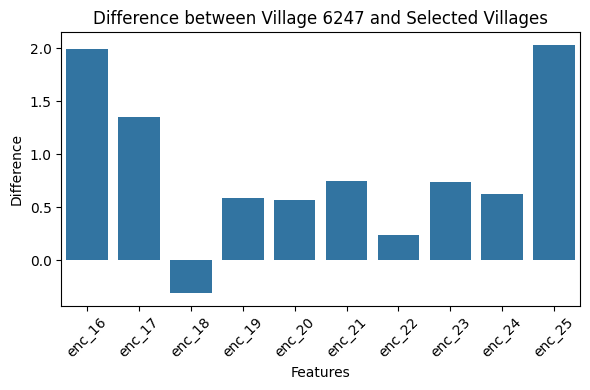

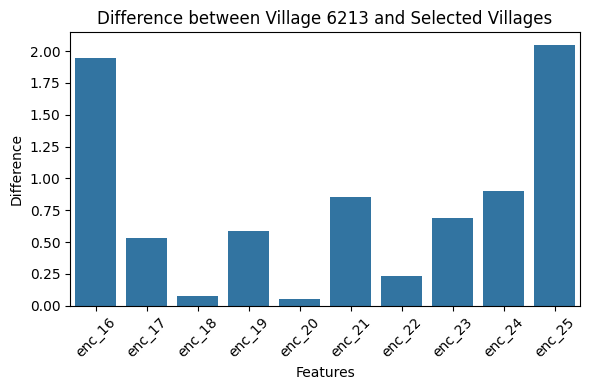

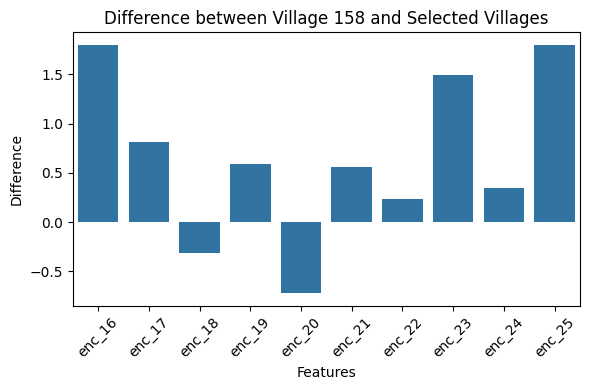

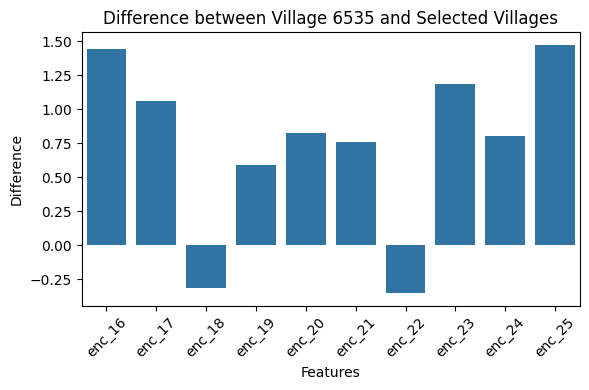

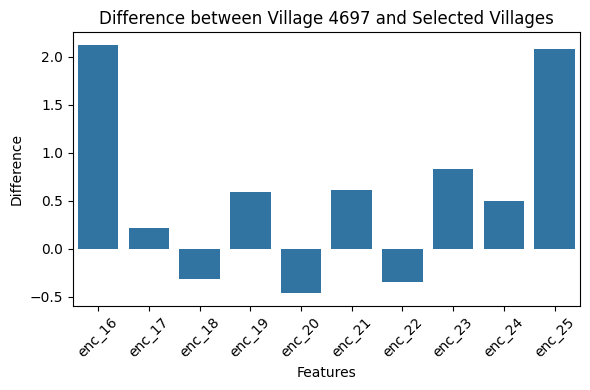

In [191]:
import seaborn as sns

# Select the specific village data
top_villages_data = df_pueblos.loc[top_villages.index, pueblos_numerical_features.columns]

# Calculate the mean of the selected columns for the selected villages
mean_values = selection_profile

# Loop through the available rows in top_villages_data
for i in range(len(top_villages_data)):
    # Calculate the difference between the mean values and the specific village data
    difference = top_villages_data.iloc[i] - mean_values

    # Create a DataFrame for the differences
    difference_df = pd.DataFrame(difference, columns=['Difference'])

    # Plot the differences
    plt.figure(figsize=(6, 4))
    sns.barplot(x=difference_df.index, y='Difference', data=difference_df)
    plt.title(f'Difference between Village {top_villages.index[i]} and Selected Villages')
    plt.xlabel('Features')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Index(['cmun', 'province', 'municipality', 'altitude', 'longitude', 'latitude',
       '0-17', '18-24', '25-34', '35-54', '55+', 'male', 'female',
       'total_population', 'nearest_airport', 'closest_distance_airport',
       'nearest_train_station', 'closest_distance_train',
       'closest_distance_hospital', 'nearest_hospital',
       'closest_distance_school', 'nearest_school', 'koppen_climate',
       'description', 'number_of_houses', 'town_size', 'connectivity_score',
       'connectivity_category', 'towns_in_vicinity', 'economy_score',
       'economy_score_area', 'autonomous_community', 'hospital_distance_score',
       'school_distance_score', 'hospital_score_area', 'school_score_area',
       'train_distance_score', 'airport_distance_score', 'transport_score',
       '0-17_pct', '18-24_pct', '25-34_pct', '35-54_pct', '55+_pct',
       'age_score', 'final_age_category', 'cluster', 'pearson_correlation'],
      dtype='object')

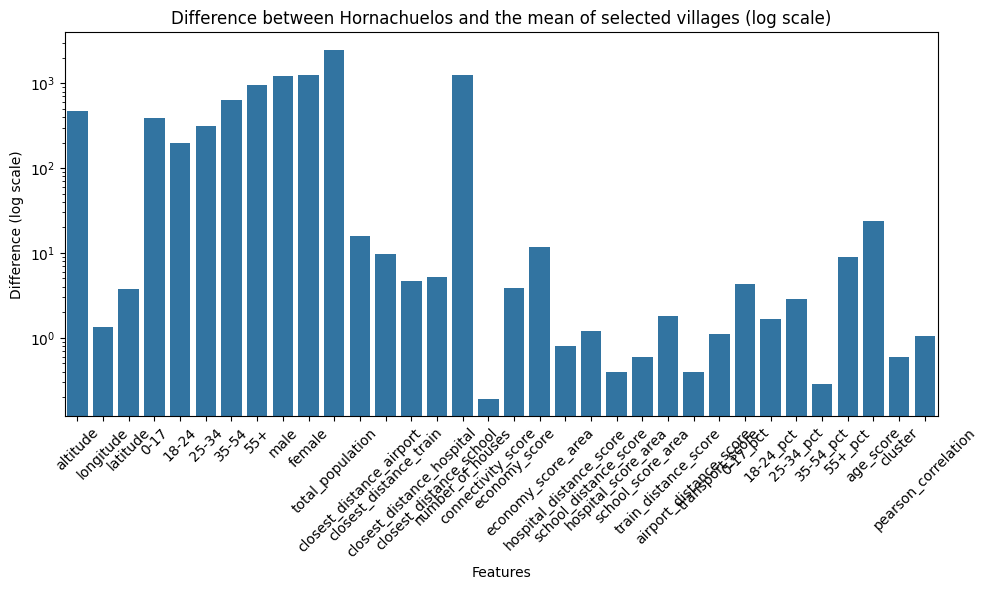

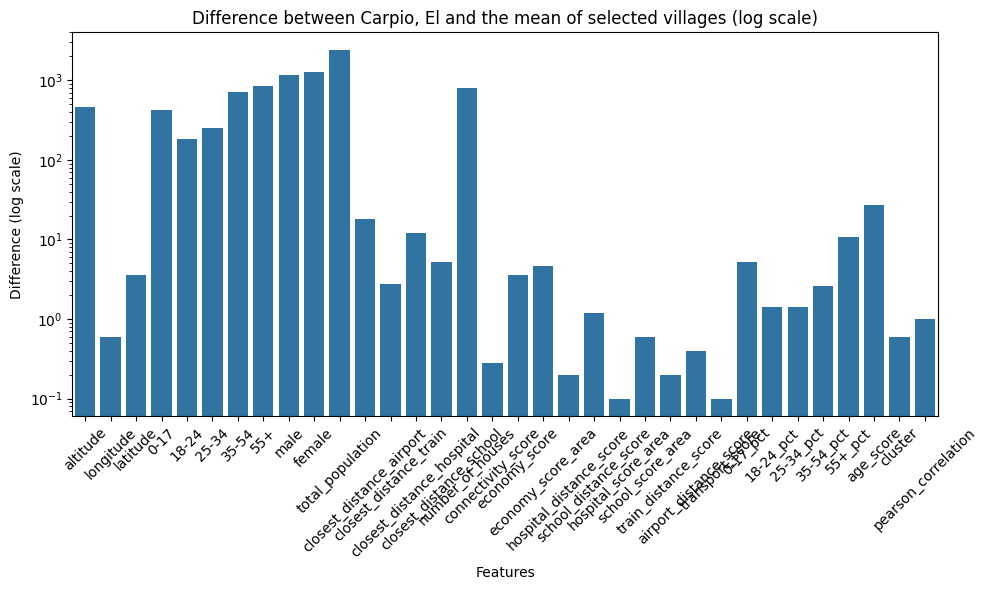

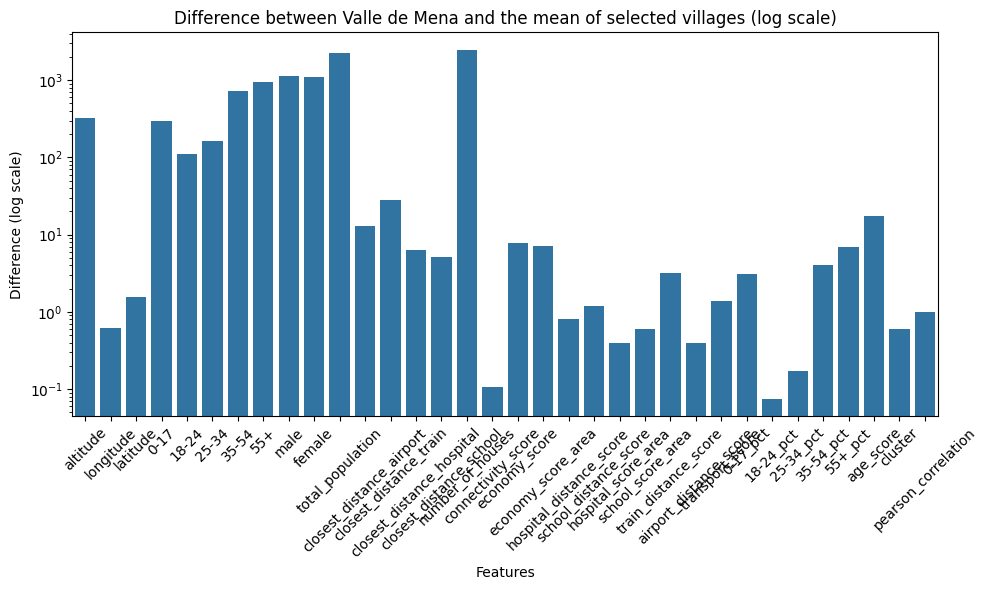

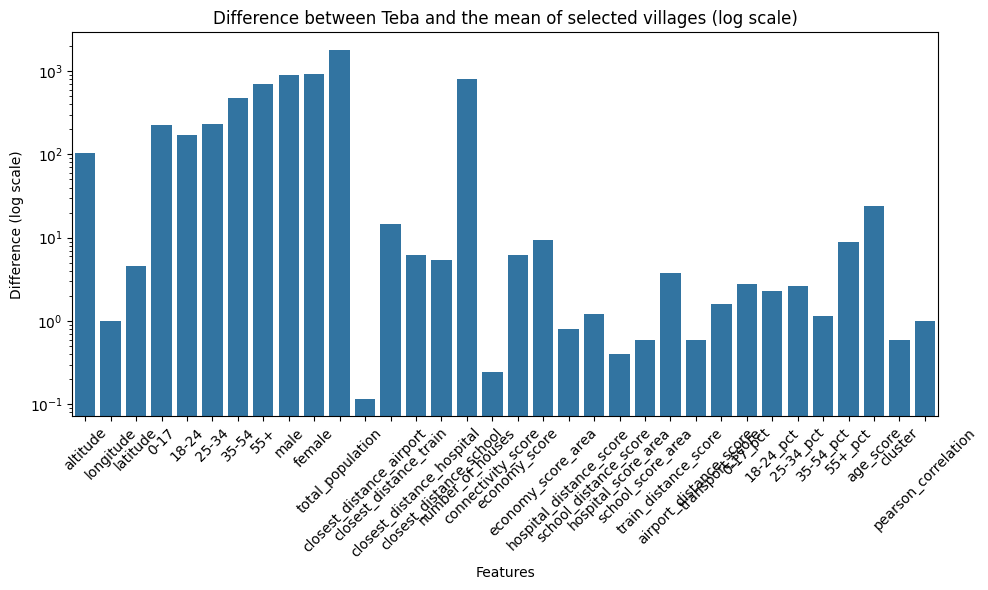

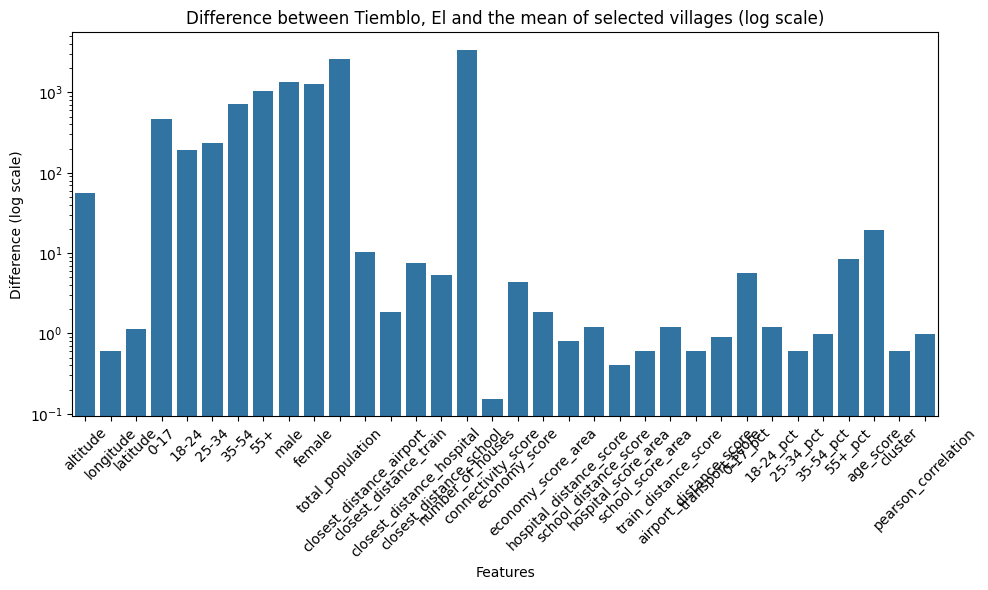

In [192]:
# Ensure 'pearson_correlation' column is present in top_villages
if 'pearson_correlation' not in top_villages.columns:
    top_villages = top_villages.join(df_pueblos['pearson_correlation'], how='left', rsuffix='_pueblos')

if 'pearson_correlation' not in selected_villages.columns:
    selected_villages = selected_villages.join(df_pueblos['pearson_correlation'], how='left', rsuffix='_pueblos')

# Filter out columns starting with 'enc_'
numerical_columns = top_villages.columns[~top_villages.columns.str.startswith('enc_') & ~top_villages.columns.str.startswith('PC')]

display(numerical_columns)

# Select only numerical columns
top_villages_numerical = top_villages[numerical_columns].select_dtypes(include=[np.number])
selected_villages_numerical = selected_villages[numerical_columns].select_dtypes(include=[np.number])

top_villages_numerical.drop(['cmun'], axis=1, inplace=True)
selected_villages_numerical.drop(['cmun'], axis=1, inplace=True)

# Calculate the mean of the selected villages
selected_villages_mean = selected_villages_numerical.mean()

# Loop through the top villages and plot the differences
for i in range(len(top_villages_numerical)):
    # Calculate the difference between the mean values and the specific village data
    difference = abs(top_villages_numerical.iloc[i] - selected_villages_mean)
    
    # Add small epsilon to avoid log(0) issues
    difference = difference.replace(0, 1e-10)
    
    # Create a DataFrame for the differences
    difference_df = pd.DataFrame(difference, columns=['Difference'])

    # Plot the differences with logarithmic scale
    plt.figure(figsize=(10, 6))
    sns.barplot(x=difference_df.index, y='Difference', data=difference_df)
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.title(f'Difference between {top_villages.iloc[i]["municipality"]} and the mean of selected villages (log scale)')
    plt.xlabel('Features')
    plt.ylabel('Difference (log scale)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Explained Variance ($r^2$):
Since Pearson correlation gives us 
𝑟, we can square it to get the explained variance.
This tells us how much of the variance in a village's features is explained by the selection profile.

In [194]:
# Calculate Explained Variance
df_pueblos['explained_variance'] = df_pueblos['pearson_correlation'] ** 2

# Show top villages with explained variance
top_villages = df_pueblos.nlargest(5, 'explained_variance')
top_villages[['municipality', 'province', 'explained_variance']]


,municipality,province,explained_variance
6247,Hornachuelos,Córdoba,0.964743
6213,"Carpio, El",Córdoba,0.891185
158,Valle de Mena,Burgos,0.883497
2716,Gallegos del Pan,Zamora,0.883244
6535,Teba,Málaga,0.880575


In [ ]:
# from scipy.stats import spearmanr

# # Calculate Spearman correlation between predicted and true scores
# spearman_corr, _ = spearmanr(true_scores, df_pueblos['pearson_correlation'])
# print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

NameError: name 'true_scores' is not defined